**Project 1 Part 3 - FLDA**

In [0]:
!pip install imageio

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
data_folder_path="gdrive/My Drive/Colab Notebooks/project1"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import skimage.io
import numpy as np
import sys
import datetime
import math
import matplotlib.pyplot as plt

In [0]:
def showgray(img):
  plt.grid(False)
  plt.imshow(img.reshape(128,128),cmap="gray")

In [0]:
def load_images_from_folder(folder):
    images = []
    images_all_channels=[]
    i_names=[]
    for filename in sorted(os.listdir(folder)):
        img = skimage.io.imread(os.path.join(folder,filename))
        if img is not None:
            img=skimage.color.rgb2hsv(img)
            img_v=img[:,:,2].flatten()
            images_all_channels.append(img)
            images.append(img_v)
            i_names.append(filename)
    return np.asarray(images,dtype=np.float64),np.asarray(images_all_channels,dtype=np.float64),i_names

male_images,male_images_rgb,_=load_images_from_folder(data_folder_path+'/male_images')
female_images,female_images_rgb,_=load_images_from_folder(data_folder_path+'/female_images')

In [0]:
#load landmarks
import scipy.io
def load_landmarks_from_folder(folder):
    images = []
    lnames=[]
    for filename in sorted(os.listdir(folder)):
        img = scipy.io.loadmat(os.path.join(folder,filename))
        if img is not None:
            images.append(img['lms'].flatten())
            lnames.append(filename)
    return np.array(images),lnames
male_landmarks,_=load_landmarks_from_folder(data_folder_path+'/male_landmarks')
female_landmarks,_=load_landmarks_from_folder(data_folder_path+'/female_landmarks')

In [0]:
!cp 'gdrive/My Drive/Colab Notebooks/mywarper.py' mywarper.py
import mywarper
#center images
def align_image_set_to_warping(img_set,landmark_set,landmark):
  res_set=np.zeros(img_set.shape)
  for i,img in enumerate(img_set):
    res_set[i]=mywarper.warp(img.reshape(128,128,1),landmark_set[i].reshape(68,2),landmark.reshape(68,2)).flatten()
  return res_set

In [0]:
#center male and female faces to mean landmarks
male_landmarks_mean=male_landmarks.mean(axis=0)
female_landmarks_mean=female_landmarks.mean(axis=0)
male_images_warped=align_image_set_to_warping(male_images,male_landmarks,male_landmarks_mean)
female_images_warped=align_image_set_to_warping(female_images,female_landmarks,female_landmarks_mean)

In [0]:
#create training set and label set for PCA, we get train_set, test_set
from sklearn.model_selection import train_test_split

dataset=np.concatenate((male_images_warped,female_images_warped))

l_dataset=np.concatenate((male_landmarks,female_landmarks))

train_set,test_set=train_test_split(dataset,train_size=800,test_size=200,shuffle=True)
l_train_set,l_test_set=train_test_split(l_dataset,train_size=800,test_size=200,shuffle=True)

In [0]:
#sklearn PCA for appearance
from sklearn.decomposition import PCA

def sklearnPCA(dataset,components):
  mean=dataset.mean(axis=0)
  x=dataset-mean
  pca = PCA(n_components=components)
  transformed_x=pca.fit_transform(x)
  return pca,transformed_x

pca,reduced_trainset=sklearnPCA(train_set,50)
eigen_v=pca.components_

#PCA for landmarks
def landmarkPCA(dataset):
  x=dataset-dataset.mean(axis=0)
  cov_x=np.matmul(x.T,x)
  eig_val,eig_v=np.linalg.eig(cov_x)
  
  #sort eigen values and vectors
  indexes_eig = eig_val.argsort()[::-1]   
  eig_val = eig_val[indexes_eig]
  eig_v = eig_v[:,indexes_eig]
  eig_val=eig_val/dataset.shape[0]
  
  return eig_val,eig_v.T

landmark_val,landmark_eig_v=landmarkPCA(l_train_set)
landmark_eig_v=landmark_eig_v[:10]
landmark_val=landmark_val[:10]

def reduce(data,eig_v):
  #return np.matmul((data-data.mean(axis=0)),eig_v.T)
  return np.matmul((data),eig_v.T)

In [0]:
#find reduced form of male and female faces
#male_images_pca=reduce(male_images_warped,eigen_v)
#female_images_pca=reduce(female_images_warped,eigen_v)
male_images_pca=pca.transform(male_images_warped)
female_images_pca=pca.transform(female_images_warped)

male_landmarks_pca=reduce(male_landmarks,landmark_eig_v)
female_landmarks_pca=reduce(female_landmarks,landmark_eig_v)


# male_images_pca=np.matmul((male_images),eigen_v.T)
# female_images_pca=np.matmul((female_images),eigen_v.T)

In [0]:
#combine pca representation to get male and female represenation in 60 dimensions
male_combined_pca=np.concatenate((male_images_pca,male_landmarks_pca),axis=1)
female_combined_pca=np.concatenate((female_images_pca,female_landmarks_pca),axis=1)

#find mean pca for males and females
male_pca_mean=male_combined_pca.mean(axis=0)
female_pca_mean=female_combined_pca.mean(axis=0)

In [0]:
#find random training set for fisher linear
def randomize_dataset_fld(male_combined_pca,female_combined_pca):
  total_females_test=np.random.randint(50,150)
  total_males_test=200-total_females_test
  total_females_train=female_combined_pca.shape[0]-total_females_test
  total_males_train=male_combined_pca.shape[0]-total_males_test
  print(total_females_train,total_males_train,total_females_test,total_males_test)

  train_set_males_fld,test_set_males_fld=train_test_split(male_combined_pca,train_size=total_males_train,test_size=total_males_test,shuffle=True)
  train_set_females_fld,test_set_females_fld=train_test_split(female_combined_pca,train_size=total_females_train,test_size=total_females_test,shuffle=True)
  
  return (train_set_males_fld,test_set_males_fld,train_set_females_fld,test_set_females_fld,total_females_test,total_males_test,total_females_train,total_males_train)

In [0]:
#Covariance matrix of both classes x-u * x-u.t and between class matrix u1-u2 * u1-u2.t
def FLDA_params(y1,y2):
  
  y1_mu=y1.mean(axis=0)
  y2_mu=y2.mean(axis=0)
  cov_y1=np.matmul((y1-y1_mu).T,(y1-y1_mu))
  cov_y2=np.matmul((y2-y2_mu).T,(y2-y2_mu))
  S_w=cov_y1+cov_y2
  
  v=(y1_mu-y2_mu)#.reshape(y1_mu.shape[0],1)
  S_b=v

  return S_w,S_b

# def find_eigens(m):
#   eig_val,eig_v=np.linalg.eig(m)
#   #sort eigen values and vectors
#   indexes_eig = eig_val.argsort()[::-1]   
#   eig_val = eig_val[indexes_eig]
#   eig_v = eig_v[:,indexes_eig]
#   eig_val=eig_val/m.shape[0]
#   return eig_v,eig_val

def plot_fisher_stats(c1,c2,h):
  import scipy.stats as stats
  m=(np.sort(c1.T)).T
  f=(np.sort(c2.T)).T
  plt.plot(m,stats.norm.pdf(m,m.mean(),m.std()))
  plt.plot(f,stats.norm.pdf(f,f.mean(),f.std()))
  plt.hist(m,h)
  plt.hist(f,h)
  plt.show()
  
def fisher_class_map(res,t):
  class_matrix=np.zeros(res.size)
  total=res.size
  for i in range(total):
    if(res[i]>t):
      class_matrix[i]=1
  return class_matrix

def fisher_error(labels,predictions):
  f_e=labels-predictions
  return len([i for i in f_e if i!=0])/labels.size

459 341 129 71


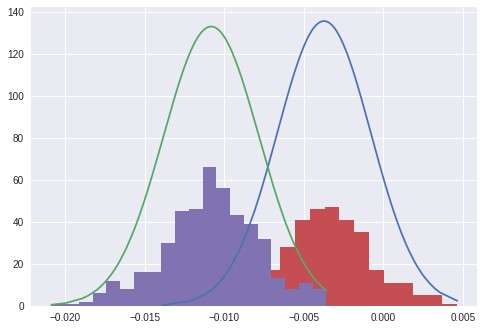

Accuracy - 89.10675381263616 %


In [0]:
#fisher face with unwarped images and 50 features
#find pca for unwarped faces
unwarped_dataset=np.concatenate((male_images,female_images))
unwarped_train_set,unwarped_test_set=train_test_split(unwarped_dataset,train_size=800,test_size=200,shuffle=True)
pca_unw,reduced_trainset=sklearnPCA(unwarped_train_set,50)
unw_eigen_v=pca_unw.components_

#reduce images
male_uw_pca=pca.transform(male_images)
female_uw_pca=pca.transform(female_images)

train_set_males_fld,test_set_males_fld,train_set_females_fld,test_set_females_fld,total_females_test,total_males_test,total_females_train,total_males_train=randomize_dataset_fld(male_uw_pca,female_uw_pca)
S_w,S_b=FLDA_params(train_set_males_fld,train_set_females_fld)

ff_uw=np.matmul(np.linalg.inv(S_w),S_b)
meanT=0.5*(train_set_males_fld.mean(axis=0)+train_set_females_fld.mean(axis=0))
uw_threshold=np.matmul(ff_uw.T,meanT)

train_males_fld_projection=np.matmul(train_set_males_fld,ff_uw)
train_females_fld_projection=np.matmul(train_set_females_fld,ff_uw)

plot_fisher_stats(train_males_fld_projection,train_females_fld_projection,20)
err=fisher_error(np.zeros(train_females_fld_projection.size),fisher_class_map(train_females_fld_projection,uw_threshold))
print("Accuracy - {} %".format(((1-err)*100)))

In [0]:
#fisher face with 60 features
train_set_males_fld,test_set_males_fld,train_set_females_fld,test_set_females_fld,total_females_test,total_males_test,total_females_train,total_males_train=randomize_dataset_fld(male_combined_pca,female_combined_pca)
S_w,S_b=FLDA_params(train_set_males_fld,train_set_females_fld)

fisher_face=np.matmul(np.linalg.inv(S_w),S_b)
meanT=0.5*(train_set_males_fld.mean(axis=0)+train_set_females_fld.mean(axis=0))
threshhold=np.matmul(fisher_face.T,meanT)

504 296 84 116


In [0]:
threshhold

-0.054317826748327254

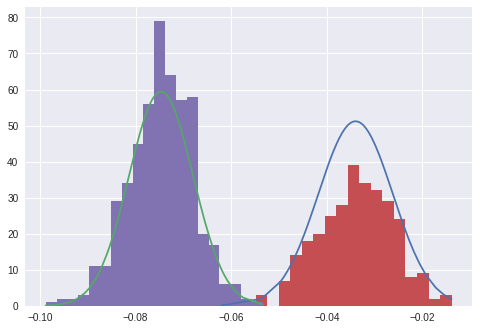

Accuracy - 99.8015873015873 %


In [0]:
train_males_fld_projection=np.matmul(train_set_males_fld,fisher_face)
train_females_fld_projection=np.matmul(train_set_females_fld,fisher_face)

plot_fisher_stats(train_males_fld_projection,train_females_fld_projection,20)
err=fisher_error(np.zeros(train_females_fld_projection.size),fisher_class_map(train_females_fld_projection,threshhold))
print("Accuracy - {} %".format(((1-err)*100)))

In [0]:
test_set_fld=np.concatenate((test_set_males_fld,test_set_females_fld))
test_fld_projection=np.matmul(test_set_fld,fisher_face)
test_fld_labels=np.concatenate((np.ones(total_males_test),np.zeros(total_females_test)))
print(fisher_error(test_fld_labels,fisher_class_map(test_fld_projection,threshhold)))

0.005


**Part 2**

In [0]:
train_set_males_fld,test_set_males_fld,train_set_females_fld,test_set_females_fld,total_females_test,total_males_test,total_females_train,total_males_train=randomize_dataset_fld(male_images_pca,female_images_pca)
l_train_set_males_fld,l_test_set_males_fld,l_train_set_females_fld,l_test_set_females_fld,l_total_females_test,l_total_males_test,l_total_females_train,l_total_males_train=randomize_dataset_fld(male_landmarks_pca,female_landmarks_pca)
#Fisher linear for appearance


S_w_app,S_b_app=FLDA_params(train_set_males_fld,train_set_females_fld)
#flda_eigs,flda_eig_vals=find_eigens(np.matmul(np.linalg.inv(S_w),S_b))
ff_app=np.matmul(np.linalg.inv(S_w_app),S_b_app)

#Fisher linear for geometric
S_w_geo,S_b_geo=FLDA_params(l_train_set_males_fld,l_train_set_females_fld)
#flda_eigs,flda_eig_vals=find_eigens(np.matmul(np.linalg.inv(S_w),S_b))
ff_geo=np.matmul(np.linalg.inv(S_w_geo),S_b_geo)

465 335 123 77
453 347 135 65


In [0]:
geo_projections=np.matmul(reduce(l_dataset,landmark_eig_v),ff_geo)
app_projections=np.matmul(reduce(dataset,eigen_v),ff_app)

geo_projections_male=np.matmul(male_landmarks_pca,ff_geo)
app_projections_male=np.matmul(male_images_pca,ff_app)

geo_projections_female=np.matmul(female_landmarks_pca,ff_geo)
app_projections_female=np.matmul(female_images_pca,ff_app)

app_threshold=np.matmul(ff_app.T,0.5*(male_images_pca.mean(axis=0)+female_images_pca.mean(axis=0)))
geo_threshold=np.matmul(ff_geo.T,0.5*(male_landmarks_pca.mean(axis=0)+female_landmarks_pca.mean(axis=0)))

Text(0, 0.5, 'Appearance')

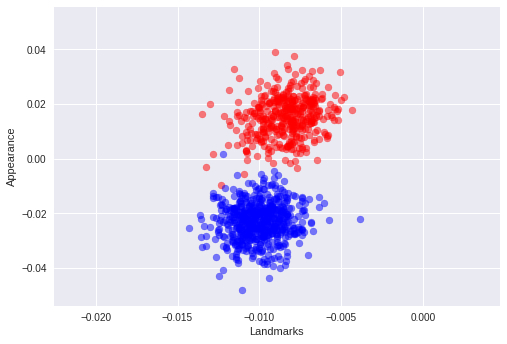

In [0]:
plt.scatter(x=geo_projections_male,y=app_projections_male,alpha=0.5,c='red',cmap="plasma")
plt.scatter(x=geo_projections_female,y=app_projections_female,alpha=0.5,c='blue',cmap="plasma")
plt.xlabel("Landmarks")
plt.ylabel("Appearance")

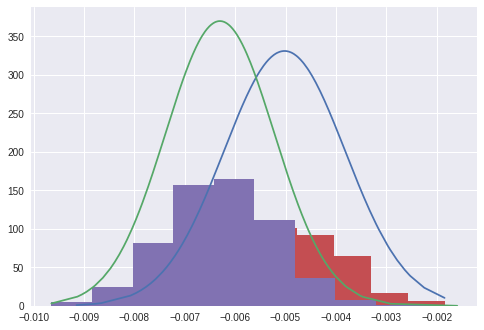

In [0]:
plot_fisher_stats(np.matmul(male_landmarks_pca,ff_geo),np.matmul(female_landmarks_pca,ff_geo),10)

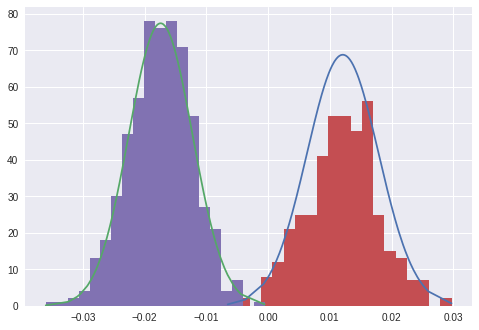

In [0]:
plot_fisher_stats(np.matmul(male_images_pca,ff_app),np.matmul(female_images_pca,ff_app),20)